## MCMC from file

Load hdf5 file from Data Fitting.ipynb that includes experiment meta data and time vs position data for MCMC analysis.

In [11]:
# import packages
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
import scipy.io
import scipy.optimize as op
import pandas as pd
import sys
sys.path.insert(0,"C:/Users/Janine/.local/share/emcee-master")
import emcee as mc
import corner
import tqdm
import warnings

from trig_fund import *
from dambreak import dambreak
from syrup_prop import Visc

# import packages for google drive
import io as IO
import pickle
import os
import os.path
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from googleapiclient.http import MediaFileUpload
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2 import service_account

# set default plotting parameters
plt.rc('font', size=22) #set default font size to 22 (from 10)
plt.rcParams['lines.linewidth'] = 4.0 #set default line width to 2.0 (from 1.0)

# filter warnings regularly ecountered in the model
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")
warnings.filterwarnings("ignore", message="divide by zero encountered in power")
warnings.filterwarnings("ignore", message="invalid value encountered in multiply")
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="invalid value encountered in less")
warnings.filterwarnings("ignore", message="overflow encountered in true_divide")

## Flow of a Herschel-Bulkley fluid on an inclined plane following derivation from Liu & Mei (1989), Balmforth et al. (2007):

$ \frac{\partial h}{\partial t} = -\left( \frac{\rho g}{K} \right)^{1/n} \frac{\partial}{\partial x} \left[ \frac{n \left| \sin{\theta} - \cos{\theta} \frac{\partial h}{\partial x} \right|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right] \left( \sin{\theta} -  \cos{\theta} \frac{\partial h}{\partial x} \right) \right] $

$ Y = h - \frac{\tau_y}{\rho g |\sin{\theta} -\cos{\theta} \frac{\partial h}{\partial x}|} $

For full derivation see included PDF "Viscoplastic Flow Derivation".

In [5]:
# import from google drive

SCOPES = ['https://www.googleapis.com/auth/drive']

"""Shows basic usage of the Drive v3 API.
Prints the names and ids of the first 10 files the user has access to.
"""
creds = None
# The file token.pickle stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token_JB.pickle'):
    with open('token_JB.pickle', 'rb') as token:
        creds = pickle.load(token)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'client_secret.json', SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open('token_JB.pickle', 'wb') as token:
        pickle.dump(creds, token)
        
service = build('drive', 'v3', credentials=creds)

# Call the Drive v3 API
results = service.files().list(q = "name contains 'MVI_0692.h5'", # change just this line to the h5 filename
    pageSize=5, fields="nextPageToken, files(id, name)").execute()
items = results.get('files', [])

if not items:
    print('No files found.')

fileid = items[0]['id']
filename =  items[0]['name']
filepath = os.getcwd()
request = service.files().get_media(fileId=fileid)
fh = IO.BytesIO()
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))

print('Saving local copy')
with IO.open(filepath + '/' + filename, 'wb') as f:
    fh.seek(0)
    f.write(fh.read())
print('Done! Loaded ' + filename)

Download 100%.
Saving local copy
Done! Loaded MVI_0692.h5


       H   K_fluid    L Particle  Phi_gas  Phi_solid    Rho  Slope  Temp  \
0  0.039  4.593487  0.2       No        0          0  1.395      0    28   

      Title  
0  MVI_0692  
       Time     X_pos
0  0.015500  0.056154
1  0.048867  0.012308
2  0.082233  0.013846
3  0.115600  0.056154
4  0.148967  0.016923


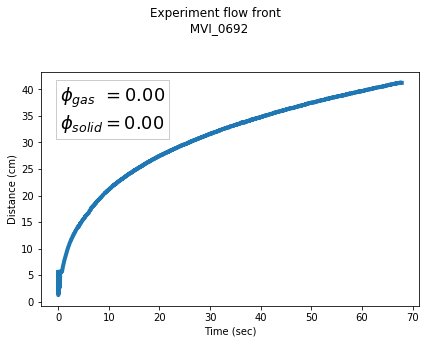

In [15]:
meta = pd.read_hdf(filename, key='meta')
print(meta)
H = meta.H[0]
L = meta.L[0]
K_fluid = meta.K_fluid[0]
rho = meta.Rho[0]*1000
theta = meta.Slope[0]
T = meta.Temp[0]
phi_gas = meta.Phi_gas[0]
phi_solid = meta.Phi_solid[0]
title_str = meta.Title[0]

dat = pd.read_hdf(filename, key='df')
print(dat.head())

t0 = 0 # Time of dam release [sec]
tloc = int(t0/(dat.Time[1] - dat.Time[0]))
t_pos = dat.Time.iloc[tloc:] - dat.Time.iloc[tloc]
x_pos = dat.X_pos.iloc[tloc:]

# plot scaled front advance
fig,ax = plt.subplots(figsize=(7,5))
ax.plot(t_pos, x_pos*100)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Distance (cm)')

textstr = '\n'.join((
    r'$\phi_{gas} \: \: =%.2f$' % (phi_gas, ),
    r'$\phi_{solid}=%.2f$' % (phi_solid, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle=None, facecolor='w', alpha=0.2)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)


fig.subplots_adjust(bottom=0.15, top=0.8, left=0.15)
fig.suptitle('Experiment flow front \n ' + title_str)
fig.savefig('Flow_front_' + title_str + '.pdf')

file_metadata = {'name': 'Flow_front_' + title_str + '.pdf', 'parents': ['1zM6oSJugXEWYybwzwO0YVvfAShTHpKbp']}
media = MediaFileUpload('Flow_front_' + title_str + '.pdf')
file = service.files().create(body=file_metadata,
                                    media_body=media).execute()
media = None

In [29]:
# Setup model for MCMC

def lnlike(mu, x, y, yerr):
    K, tauy, n = mu
    h, t = dambreak(x_grid, h0, theta, rho, K, tauy, n, 9.81, t_pos.iloc[-1], 50*t_pos.size)
    X = np.zeros_like(t_pos)
    t_match = np.zeros_like(t_pos)

    threshold = 0.0001
    for j in np.arange(t_pos.shape[0]):
        X[j] = x_grid[np.max(np.nonzero(h[j*50,:]>threshold)) + 1] # find node with h>threshold
        t_match[j] = t[j*50]
    ind = np.nonzero(X[1:] - X[:-1])[0]
    model = np.interp(t_match,t_match[ind],X[ind])
    
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*yerr**2)))

In [44]:
# Initial guesses for MCMC
K_init = 9.5
K_min = 6
K_max = 18

tauy_init = 0.02
tauy_min = 0
tauy_max = 1

n_init = 1
n_min = 0.8
n_max = 1.2

init_pos = [K_init, tauy_init, n_init]

# load data to MCMC
x = t_pos
y = x_pos + L

# Define model resolution for MCMC
x_grid = np.linspace(0,0.75,52)
dx = x_grid[1] - x_grid[0]
yerr = dx
h0 = np.zeros_like(x_grid)
h0[x_grid<0.2] = H

In [45]:
# Uniform prior distribution
def lnprior(mu):
    K, tauy, n = mu
    if K_min < K < K_max and tauy_min < tauy < tauy_max and n_min < n < n_max:
        return 0.0
    return -np.inf

def lnprob(mu, x, y, yerr):
    lp = lnprior(mu)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(mu, x, y, yerr)# Create walkers

In [46]:
# Create walkers
ndim, nwalkers = 3, 10
mu_pos = [init_pos + [1e-1, 1e-2, 1e-2]*np.random.randn(ndim) for i in range(nwalkers)]

In [47]:
# Run MCMC 
steps = 50
sampler = mc.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(mu_pos, steps, progress=True);

100%|███████████████████████████████████████| 50/50 [4:39:41<00:00, 337.61s/it]


K = 10., tau_y = 0.08, n = 1.19


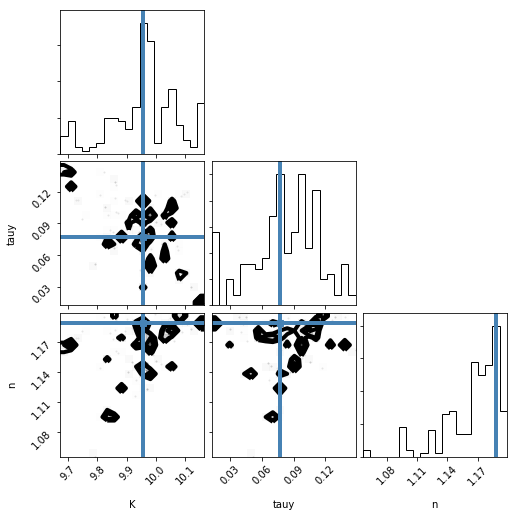

In [52]:
# Inspect MCMC results
s = 30 # ignore initial samples
samples = sampler.chain[:, s:, :].reshape((-1, ndim))

K_fit = samples[:,0]; tauy_fit = samples[:,1]; n_fit = samples[:,2]

# Find mode of each posterior distribution
N, bin_edges = np.histogram(K_fit, bins=20)
K_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(tauy_fit, bins=20)
tauy_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(n_fit, bins=20)
n_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 

# plot
fig = corner.corner(samples, labels=["K", "tauy", "n"],
                   truths=[K_post, tauy_post, n_post])
print('K = ' + np.array2string(K_post, precision=1) + 
      ', tau_y = ' + np.array2string(tauy_post, precision=2) + 
      ', n = ' + np.array2string(n_post, precision=2))

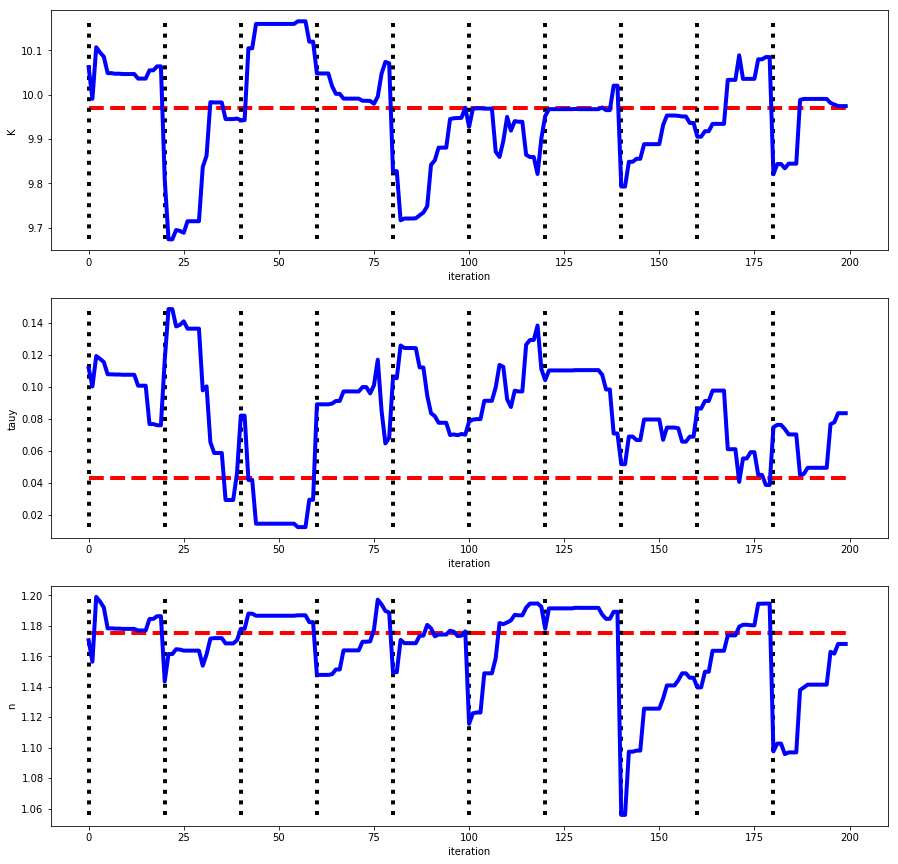

In [51]:
# inspect runs
s = 30
samples_full = sampler.chain[:, s:, :].reshape((-1, ndim))

fig,ax = plt.subplots(nrows=3, figsize=(15,15))
ax[0].plot(samples_full[:,0],'b-')
ax[0].hlines(K_post, 0, samples_full.shape[0],colors='r',linestyles='dashed')
ax[0].vlines(np.arange(nwalkers)*(steps-s),np.min(samples_full[:,0]),np.max(samples_full[:,0]),colors='k',linestyles='dotted')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('K')
ax[1].plot(samples_full[:,1],'b-')
ax[1].hlines(tauy_post, 0, samples_full.shape[0],colors='r',linestyles='dashed')
ax[1].vlines(np.arange(nwalkers)*(steps-s),np.min(samples_full[:,1]),np.max(samples_full[:,1]),colors='k',linestyles='dotted')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('tauy')
ax[2].plot(samples_full[:,2],'b-')
ax[2].hlines(n_post, 0, samples_full.shape[0],colors='r',linestyles='dashed')
ax[2].vlines(np.arange(nwalkers)*(steps-s),np.min(samples_full[:,2]),np.max(samples_full[:,2]),colors='k',linestyles='dotted')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('n');

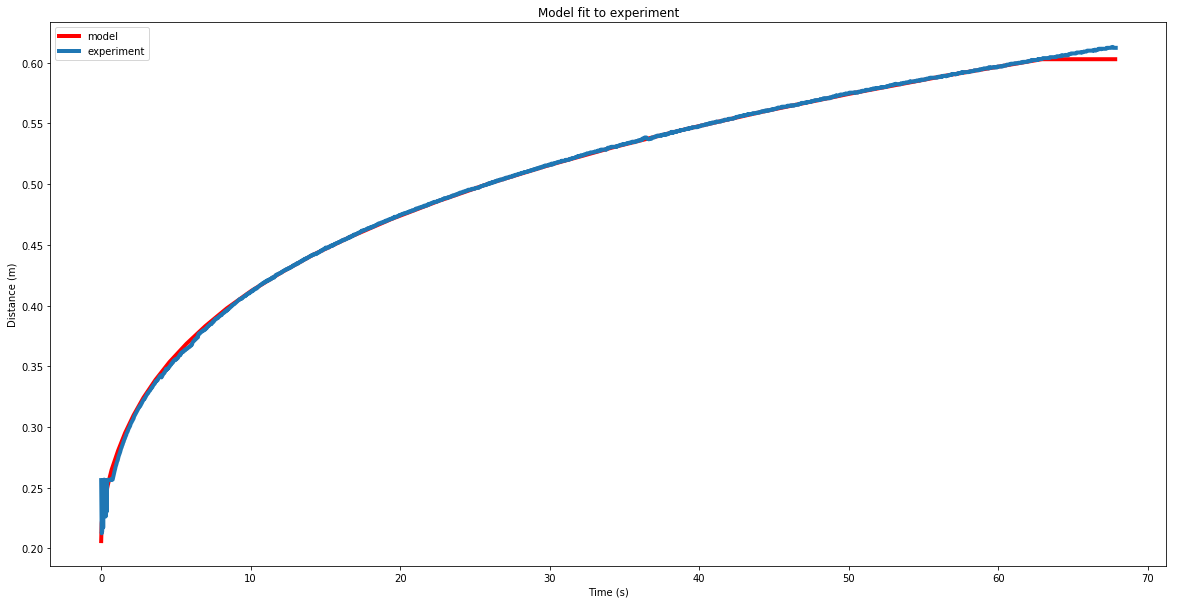

In [53]:
# Plot most probable model with data
x_grid = np.linspace(0,0.75,52)
dx = x_grid[1] - x_grid[0]
h0 = np.zeros_like(x_grid)
h0[x_grid<0.2] = H
h, t = damBreak(x_grid, h0, theta, rho, K_post, tauy_post, n_post, 9.81, t_pos.iloc[-1], 25*t_pos.size)
X = np.zeros_like(t_pos)
t_match = np.zeros_like(t_pos)

threshold = 0.0001
for j in np.arange(t_pos.size):
    X[j] = x_grid[np.max(np.nonzero(h[j*25,:]>threshold)) + 1] # find node with h>threshold
    t_match[j] = t[j*25]
    ind = np.nonzero(X[1:] - X[:-1])[0]
    model = np.interp(t_match,t_match[ind],X[ind])

# Plot front advance
fig,ax = plt.subplots(figsize=(20,10))

ax.plot(t_match,model,'r-',label='model');
ax.plot(t_pos,x_pos+L,label='experiment')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (m)')
ax.set_title('Model fit to experiment')
ax.legend();

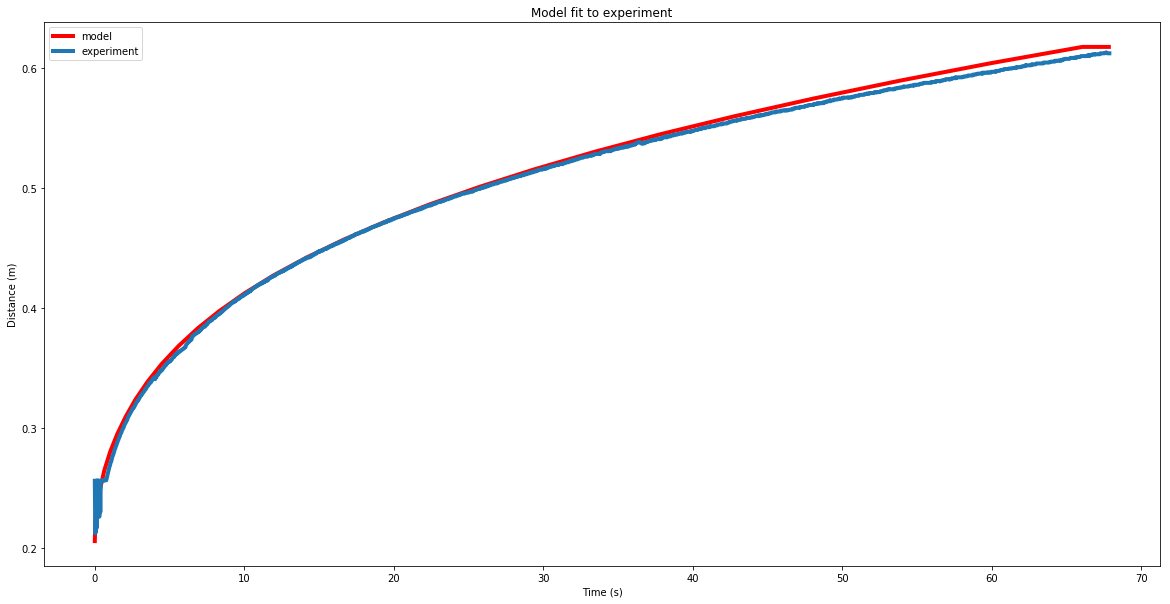

In [65]:
# Plot most probable model with data
x_grid = np.linspace(0,0.75,52)
dx = x_grid[1] - x_grid[0]
h0 = np.zeros_like(x_grid)
h0[x_grid<0.2] = H
h, t = damBreak(x_grid, h0, 0.3, 1395, 12.5, 0, 1, 9.81, t_pos.iloc[-1], 25*t_pos.size)
X = np.zeros_like(t_pos)
t_match = np.zeros_like(t_pos)

threshold = 0.0001
for j in np.arange(t_pos.size):
    X[j] = x_grid[np.max(np.nonzero(h[j*25,:]>threshold)) + 1] # find node with h>threshold
    t_match[j] = t[j*25]
    ind = np.nonzero(X[1:] - X[:-1])[0]
    model = np.interp(t_match,t_match[ind],X[ind])

# Plot front advance
fig,ax = plt.subplots(figsize=(20,10))

ax.plot(t_match,model,'r-',label='model');
ax.plot(t_pos,x_pos+L,label='experiment')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (m)')
ax.set_title('Model fit to experiment')
ax.legend();

In [26]:
# Save posterior distribution

s = 0 # ignore initial samples
samples = sampler.chain[:, s:, :].reshape((-1, ndim))
K_fit = samples[:,0]; tauy_fit = samples[:,1]; n_fit = samples[:,2]


meta['K_post'] = K_post
meta['K_r'] = K_post/K_fluid
meta['tauy_post'] = tauy_post
meta['n_post'] = n_post

meta.to_hdf(title_str + '.h5', key='meta', mode='a')

samples = pd.DataFrame({'K':K_fit, 'tauy':tauy_fit, 'n':n_fit})
samples.to_hdf(title_str + '.h5', key='s', mode='a')

file_metadata = {'name': title_str + '.h5', 'parents': ['1zM6oSJugXEWYybwzwO0YVvfAShTHpKbp']}
media = MediaFileUpload(title_str + '.h5')
file = service.files().create(body=file_metadata,
                                    media_body=media).execute()

ConnectionAbortedError: [WinError 10053] An established connection was aborted by the software in your host machine

In [ ]:
# remove local files after upload
media = None
os.remove(filename)